# BBCA Stock Price Prediction Model

## Project Background
Forecasting stock prices is an important task for both individual and institutional investors. The high volatility and non-linear patterns in financial markets make accurate prediction challenging. In this project, we use the Long Short-Term Memory (LSTM) model—a type of Recurrent Neural Network (RNN)—to forecast BBCA (Bank Central Asia) stock prices using historical data. This model is selected for its ability to capture long-term dependencies and complex temporal dynamics in time series data. Our goal is to evaluate LSTM performance in terms of accuracy and applicability for financial forecasting.

## Dataset
In this project, we use the daily historical stock prices of Bank Central Asia (BBCA) from January 2, 2020 to March 18, 2025 provided by investing.com, with the column descriptions provided below.

- `Price`: The closing price of the stock
- `Open`: The opening price of the stock
- `High`: The highest price of the stock
- `Low`: The lowest price of the stock
- `Vol.`: The total number of shares traded in a single day

In [12]:
# import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import datetime as dt

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

import warnings
warnings.filterwarnings("ignore")

### Import Data

In [13]:
# load dataset
stock_data = pd.read_csv("bbca.csv")
stock_data

,Date,Price,Open,High,Low,Vol.,Change %
0,03/18/2025,"8,200","8,525","8,550","8,075",202.71M,-4.65%
1,03/17/2025,"8,600","8,750","8,775","8,550",151.37M,-1.71%
2,03/14/2025,"8,750","8,800","8,925","8,750",111.40M,-2.51%
3,03/13/2025,"8,975","9,150","9,175","8,975",83.03M,-1.64%
4,03/12/2025,"9,125","9,025","9,125","8,975",87.97M,2.24%
...,...,...,...,...,...,...,...
1257,01/08/2020,"6,680","6,670","6,745","6,670",53.69M,-0.89%
1258,01/07/2020,"6,740","6,735","6,770","6,730",45.02M,0.07%
1259,01/06/2020,"6,735","6,720","6,750","6,690",27.30M,-0.96%
1260,01/03/2020,"6,800","6,750","6,800","6,725",47.76M,1.64%


In [14]:
stock_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1262 entries, 0 to 1261
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Date      1262 non-null   object
 1   Price     1262 non-null   object
 2   Open      1262 non-null   object
 3   High      1262 non-null   object
 4   Low       1262 non-null   object
 5   Vol.      1262 non-null   object
 6   Change %  1262 non-null   object
dtypes: object(7)
memory usage: 69.1+ KB


In [15]:
# check duplicates and null value
def check_data(dataset):
    print(f"Number of duplicates: {dataset.duplicated().sum()}")
    print(f"Number of null values: {dataset.isnull().sum().sum()}")
    
check_data(stock_data)

Number of duplicates: 0
Number of null values: 0


This dataset has **1,262** data points with no missing values or duplicates. However, the *object* data types are not suitable for a time series model, so we need to make changes. First, we need to convert `Date` column into a proper datetime format which ensures that the model can interpret the data patterns over time. For better clarity, the column name "Price" is also renamed to "Close", as it represents the closing price of the stock.

This financial data also contains values in string form caused by the use of notations (e.g., **'M'** for millions, **'B'** for billions, or formatted with commas). Thus, we also need to convert those values into float using a helper function applied into key columns which are `Open`, `High`, `Low`, `Close`, and `Vol.`.

In [16]:
# convert into datetime
stock_data['Date'] = pd.to_datetime(stock_data['Date'], format='%m/%d/%Y')

# change column name 'Price' into 'Close' for clarity
stock_data.rename(columns={'Price': 'Close'}, inplace=True)

# standardize data
def parse_numeric(value):
    if isinstance(value, str):
        if 'M' in value:
            return float(value.replace('M', '')) * 1e6
        elif 'B' in value:
            return float(value.replace('B', '')) * 1e9
        else:
            return float(value.replace(',', ''))
    return value

for column in ['Open', 'High', 'Low', 'Close', 'Vol.']:
    if column in stock_data.columns:
        stock_data[column] = stock_data[column].apply(parse_numeric)

# sort data by Date
stock_data = stock_data.sort_values('Date')
stock_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1262 entries, 1261 to 0
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   Date      1262 non-null   datetime64[ns]
 1   Close     1262 non-null   float64       
 2   Open      1262 non-null   float64       
 3   High      1262 non-null   float64       
 4   Low       1262 non-null   float64       
 5   Vol.      1262 non-null   float64       
 6   Change %  1262 non-null   object        
dtypes: datetime64[ns](1), float64(5), object(1)
memory usage: 78.9+ KB


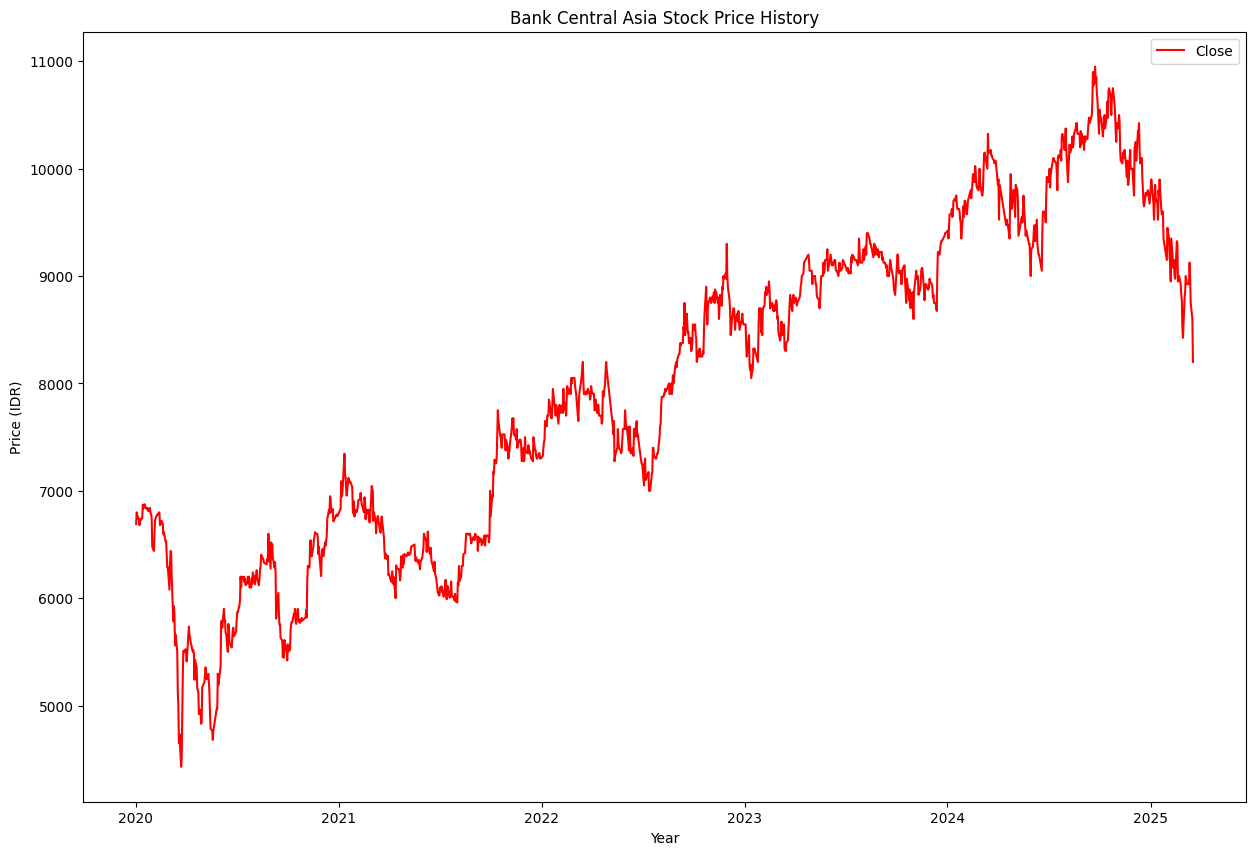

In [17]:
# plot data
plt.figure(figsize=(15, 10))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.gca().xaxis.set_major_locator(mdates.YearLocator())

x_dates = stock_data['Date']

plt.plot(x_dates, stock_data['Close'], 'r', label='Close')
plt.xlabel('Year')
plt.ylabel('Price (IDR)')
plt.title('Bank Central Asia Stock Price History')
plt.legend()
plt.gcf()
plt.show()

### Data Preprocessing

To enhance the result of the prediction, we add several calculations below as features.
- **50-day Moving Average (MA_50):** Captures short-term trends (over the past 50 days) in the stock price, helping to smooth out daily price fluctuations.
- **200-day Moving Average (MA_200):** Captures long-term trends (over the past 200 days) in the stock price, providing insights into the overall direction of the market.
- **Daily Returns (Returns):** Calculated as the percentage change in the stock's closing price from one day to the next, reflecting daily price movement.
- **Daily Trading Range (Range):** The difference between the highest and lowest price of the stock on a given day, providing insights into daily market activity.
- **Closing Price vs. 50-day Moving Average (Close_MA_50_diff):** The difference between the closing price and the 50-day moving average, indicating whether the stock is trading above or below its recent trend.


In [18]:
def compute_rsi(series, period=30):
    delta = series.diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=period).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=period).mean()
    rs = gain / loss
    rsi = 100 - (100 / (1 + rs))
    return rsi

# Feature Engineering
stock_data['MA_50'] = stock_data['Close'].rolling(window=50).mean()
stock_data['MA_200'] = stock_data['Close'].rolling(window=200).mean()
stock_data['Returns'] = stock_data['Close'].pct_change()
stock_data['Range'] = stock_data['High'] - stock_data['Low']
stock_data['Close_MA_50_diff'] = stock_data['Close'] - stock_data['MA_50']
stock_data['RSI_14'] = compute_rsi(stock_data['Close'], period=14)
stock_data.dropna(inplace=True)

# Select features
features = ['Close', 'MA_50', 'MA_200', 'Returns', 'Range','RSI_14', 'Close_MA_50_diff', 'Vol.']

# scale close price as target column into 0 to 1
scaler_close = MinMaxScaler()
scaled_close = scaler_close.fit_transform(stock_data[['Close']])

# scale features into 0 to 1
scaler_features = MinMaxScaler()
scaled_others = scaler_features.fit_transform(stock_data[features[1:]])

# combine scaled target column and fetures
scaled_data = np.concatenate([scaled_close, scaled_others], axis=1)

# split dataset into 80% training dataset and 20% testing dataset
dates = stock_data['Date'].values
look_back = 30
split_idx = int(len(scaled_data) * 0.8)
train_data = scaled_data[:split_idx]
test_data = scaled_data[split_idx - look_back:]

# create sequences
def create_sequences(data, look_back):
    x, last_closes, next_closes = [], [], []
    for i in range(look_back, len(data)):
        x.append(data[i - look_back:i])
        last_closes.append(data[i - 1, 0])
        next_closes.append(data[i, 0])
    return np.array(x), np.array(last_closes), np.array(next_closes)

x_train, last_train_scaled, next_train_scaled = create_sequences(train_data, look_back)
x_test, last_test_scaled, next_test_scaled = create_sequences(test_data, look_back)

# Unscale close price
def unscale_closes(scaled_closes):
    return scaler_close.inverse_transform(scaled_closes.reshape(-1, 1)).ravel()

last_train_actual = unscale_closes(last_train_scaled)
next_train_actual = unscale_closes(next_train_scaled)
y_train = (next_train_actual - last_train_actual) / last_train_actual

## Model Building: Long Short Term Memory (LSTM)

In [19]:
# LSTM Model
model = Sequential()
model.add(LSTM(64, return_sequences=True, input_shape=(x_train.shape[1], x_train.shape[2]), kernel_regularizer=l2(0.001)))
model.add(Dropout(0.3))  # More dropout for regularization
model.add(LSTM(64, return_sequences=False, kernel_regularizer=l2(0.001)))
model.add(Dropout(0.3))
model.add(Dense(1, kernel_regularizer=l2(0.001)))

model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')

early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history = model.fit(
    x_train, y_train,
    epochs=100,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stop],
    verbose=1
)

# save the trained model
model.save('lstm_stock_model.keras')

# predict price changes and add it to the last closing price
predicted_delta = model.predict(x_test).ravel()
last_test_actual = unscale_closes(last_test_scaled)
next_test_actual = unscale_closes(next_test_scaled)
predicted_close = last_test_actual * (1 + predicted_delta)
actual_close = next_test_actual

Epoch 1/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 7s 79ms/step - loss: 0.1196 - val_loss: 0.0870
Epoch 2/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - loss: 0.0809 - val_loss: 0.0610
Epoch 3/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - loss: 0.0566 - val_loss: 0.0433
Epoch 4/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - loss: 0.0403 - val_loss: 0.0314
Epoch 5/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - loss: 0.0295 - val_loss: 0.0236
Epoch 6/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - loss: 0.0223 - val_loss: 0.0182
Epoch 7/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - loss: 0.0173 - val_loss: 0.0146
Epoch 8/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - loss: 0.0140 - val_loss: 0.0120
Epoch 9/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - loss: 0.0116 - val_loss: 0.0101
Epoch 10/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - loss: 0.0098 - val_loss: 0.0086
Epoch 11/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - loss: 0.0083 - val_loss: 0.0074
Epoch 12/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step

In [20]:
mse = mean_squared_error(actual_close, predicted_close)
rmse = np.sqrt(mse)
mae = mean_absolute_error(actual_close, predicted_close)
mape = np.mean(np.abs((actual_close - predicted_close) / actual_close)) * 100
r2 = r2_score(actual_close, predicted_close)

print("\nLSTM Evaluation Metrics:")
print(f"LSTM MSE:   {mse:.4f}")
print(f"LSTM RMSE:  {rmse:.4f}")
print(f"LSTM MAE:   {mae:.4f}")
print(f"LSTM MAPE:  {mape:.2f}%")
print(f"LSTM R²:    {r2:.4f}")


LSTM Evaluation Metrics:
LSTM MSE:   22820.8863
LSTM RMSE:  151.0658
LSTM MAE:   118.5276
LSTM MAPE:  1.21%
LSTM R²:    0.9272


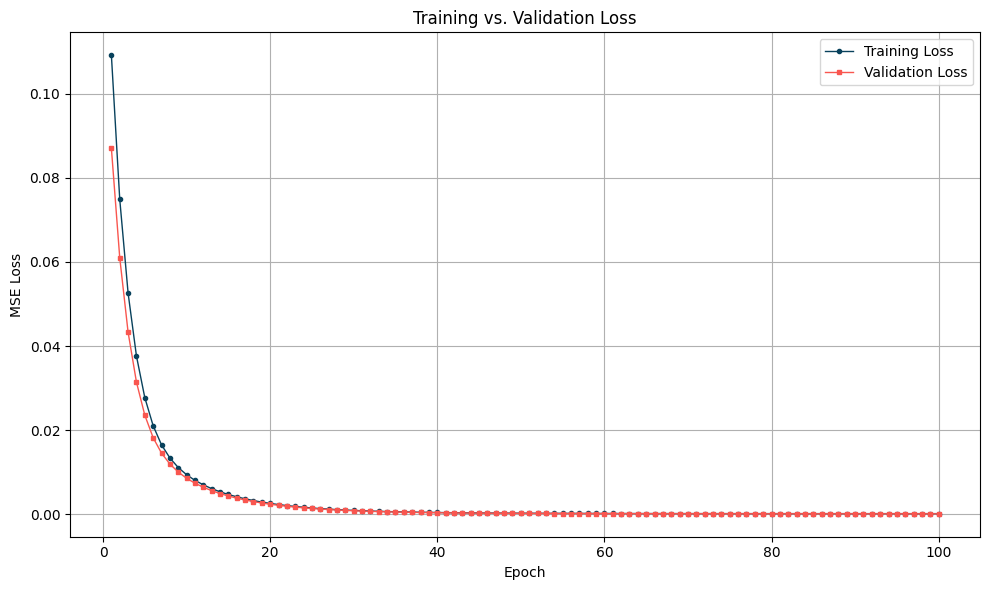

In [21]:
# plot training loss and validation loss
train_loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = list(range(1, len(train_loss) + 1))

plt.figure(figsize=(10, 6))
plt.plot(epochs, train_loss, label='Training Loss', marker='o', markersize=3, linewidth=1, color='#08415C')
plt.plot(epochs, val_loss, label='Validation Loss', marker='s',  markersize=3, linewidth = 1, color='#F9564F')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.title('Training vs. Validation Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

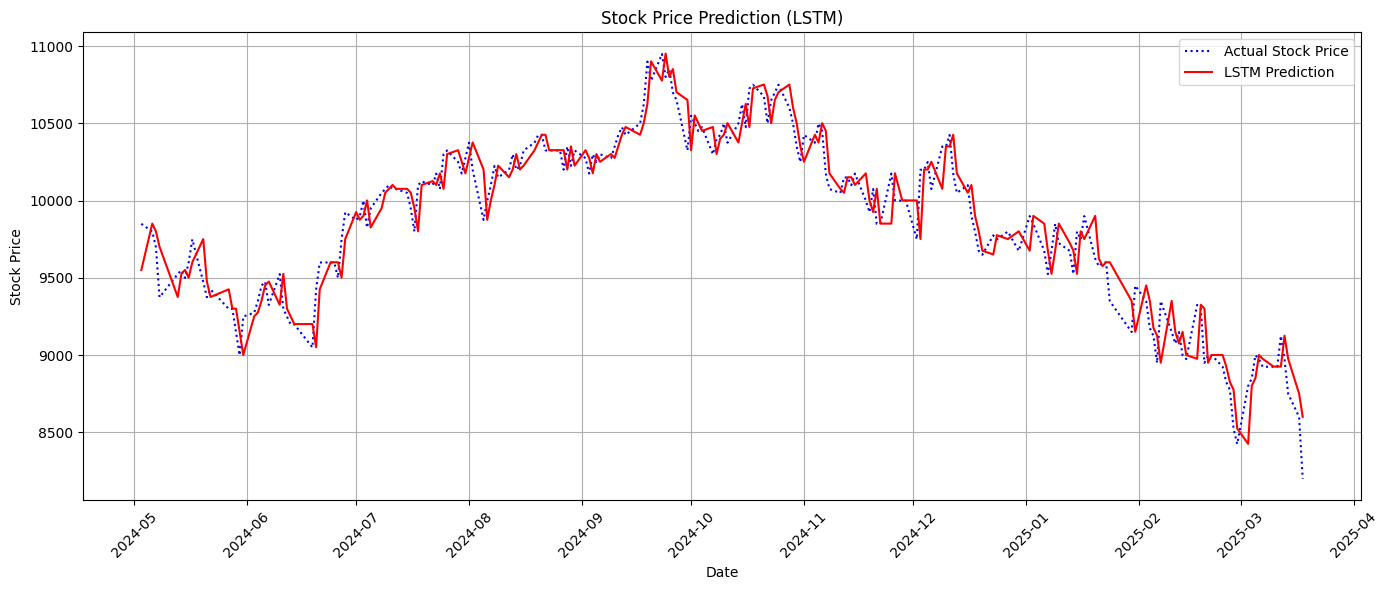

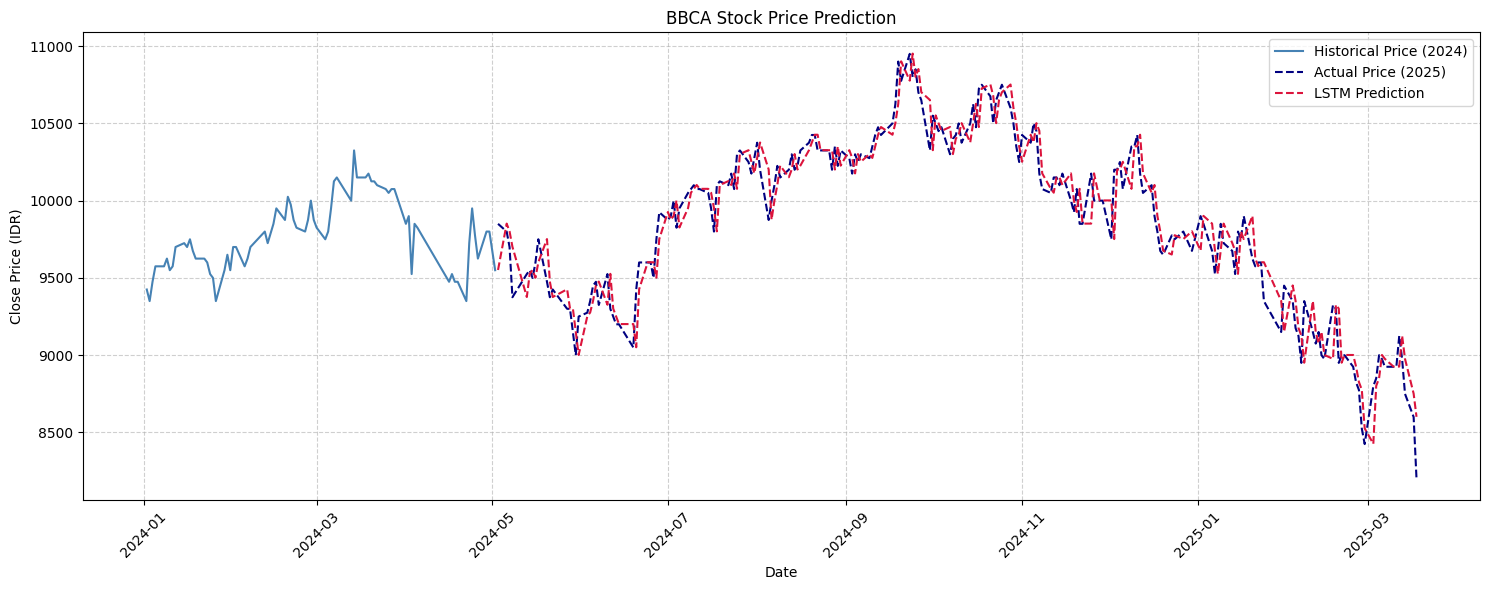

In [22]:
# Visualize Prediction Result
test_data_start_index = len(stock_data) - len(actual_close)
test_dates = stock_data['Date'].iloc[test_data_start_index:].reset_index(drop=True)

# Actual vs LSTM
plt.figure(figsize=(14, 6))
plt.plot(test_dates, actual_close, color='blue', linestyle='dotted', label='Actual Stock Price')
plt.plot(test_dates, predicted_close, color='red', label='LSTM Prediction')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.title('Stock Price Prediction (LSTM)')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Overall Stock Price Movement
historical_start = '2024-01-01'
historical_mask = (stock_data['Date'] >= historical_start) & (stock_data['Date'] < test_dates.iloc[0])
dates_historical = stock_data.loc[historical_mask, 'Date'].reset_index(drop=True)
historical_prices = stock_data.loc[historical_mask, 'Close'].reset_index(drop=True)

plt.figure(figsize=(15, 6))
plt.plot(dates_historical, historical_prices, label='Historical Price (2024)', color='steelblue')
plt.plot(test_dates, actual_close, label='Actual Price (2025)', color='navy', linestyle='dashed')
plt.plot(test_dates, predicted_close, label='LSTM Prediction', color='crimson', linestyle='--')
plt.title('BBCA Stock Price Prediction')
plt.xlabel('Date')
plt.ylabel('Close Price (IDR)')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()